# **Research Notebook 03: Baseline Model (Logistic Regression with Hyperparameter Tuning)**

**Objective:** To build, train, and evaluate our baseline model (Logistic Regression with TF-IDF) to establish a performance benchmark.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib
import time

In [2]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define File Paths

base_path = '/content/drive/MyDrive/Research/'
datasets_path = f'{base_path}datasets/'
models_path = f'{base_path}models/'

train_path = f'{datasets_path}train_dataset.csv'
test_path = f'{datasets_path}test_dataset.csv'

model_save_path = f'{models_path}baseline_model.pkl'

In [4]:
# Load Datasets

print("---Baseline Model Development---")

print("\nLoading datasets...")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Drop any potential NaN rows
# We use the column we prepared for this model: 'cleaned_text_tfidf'
train_df = train_df.dropna(subset=['cleaned_text_tfidf'])
test_df = test_df.dropna(subset=['cleaned_text_tfidf'])

print(f"Training set loaded: {len(train_df)} articles")
print(f"Testing set loaded: {len(test_df)} articles")

---Baseline Model Development---

Loading datasets...
Training set loaded: 9028 articles
Testing set loaded: 2258 articles


In [5]:
# Prepare Data for Modeling

print("Prepare Data for Modeling...")

# X contains the features (our text)
# We use the 'cleaned_text_tfidf' column
X_train = train_df['cleaned_text_tfidf']
X_test = test_df['cleaned_text_tfidf']

# y contains the target labels
y_train = train_df['label']
y_test = test_df['label']

print("\nData prepared for modeling.")

Prepare Data for Modeling...

Data prepared for modeling.


In [6]:
# Create the Pipeline

print("Creating a machine learning pipeline...")
# A Pipeline chains our steps together.
# 1. 'tfidf': Run the TF-IDF Vectorizer
# 2. 'clf': Run the Logistic Regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42, solver='liblinear'))
])

print("\nCreated a machine learning piepline.")

Creating a machine learning pipeline...

Created a machine learning piepline.


In [7]:
# Define Parameter Grid for GridSearchCV

print("Defining the parameter grid for tuning...")

parameters = {
    'tfidf__max_features': [5000, 7500, 10000],  # Test 3 different vocab sizes
    'tfidf__ngram_range': [(1, 1), (1, 2)],   # Test single words vs. two-word phrases
    'clf__penalty': ['l1', 'l2'],             # Test L1 vs L2 penalty
    'clf__C': [0.1, 1.0, 10.0]                 # Test different regularization strengths
}

print("\nCreated parameter grid for tuning...")

Defining the parameter grid for tuning...

Created parameter grid for tuning...


In [8]:
# Run GridSearchCV

print("Starting GridSearchCV...")

# Define our Cross-Validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.time()
grid_search = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"\nGridSearchCV finished in {(end_time - start_time):.2f} seconds.")

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

GridSearchCV finished in 905.26 seconds.


In [9]:
# Show Best Parameters

print("Analyzing tuning results...")
print(f"\nBest cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

Analyzing tuning results...

Best cross-validation score (Accuracy): 0.9790
Best parameters found:
{'clf__C': 10.0, 'clf__penalty': 'l1', 'tfidf__max_features': 7500, 'tfidf__ngram_range': (1, 2)}


In [10]:
# Evaluate the Best Model on the Test Set

print("Evaluating the best model on the unseen test set...")
y_pred = grid_search.predict(X_test)

# Create a new DataFrame to see the results
results_df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred
})

# Print the first 10 results
print("\n--- Comparison of True vs. Predicted Labels ---\n")
results_df.head(10)

Evaluating the best model on the unseen test set...

--- Comparison of True vs. Predicted Labels ---



,text,true_label,predicted_label
0,president trump is scheduled to attend the wre...,fake,fake
1,the breaking point is fast approaching in a di...,fake,fake
2,andrew mccarthy is just awesome he goes throug...,fake,fake
3,the u s department of defense and lockheed mar...,real,real
4,chancellor angela merkel is working to set a d...,real,real
5,the insatiable news cycle bolstered by cellpho...,fake,fake
6,nyc mayor bill de blasio is really pushing it ...,fake,fake
7,london oct reuters officials from the u s gove...,real,real
8,hillary clinton told a group of graduates how ...,fake,fake
9,president barack obama s advisers would recomm...,real,real


In [11]:
# --- Key Performance Metrics ---

# We need probabilities for the ROC AUC score
# We also need to map our text labels to 0s and 1s for the ROC functions
y_test_numeric = y_test.map({'fake': 0, 'real': 1})
y_pred_probs = grid_search.predict_proba(X_test)[:, 1] # Probability of 'real'

# Calculate main scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
auc_score = roc_auc_score(y_test_numeric, y_pred_probs)

print(f"--- Final Model Accuracy:   {accuracy * 100:.2f}%")
print(f"--- Final Model Precision (Macro): {precision * 100:.2f}%")
print(f"--- Final Model Recall (Macro):    {recall * 100:.2f}%")
print(f"--- Final Model F1-Score (Macro):  {f1 * 100:.2f}%")
print(f"--- Final Model ROC AUC Score:     {auc_score * 100:.2f}%")

--- Final Model Accuracy:   98.27%
--- Final Model Precision (Macro): 98.27%
--- Final Model Recall (Macro):    98.27%
--- Final Model F1-Score (Macro):  98.27%
--- Final Model ROC AUC Score:     99.79%


In [12]:
# Print the detailed classification report

print("--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['fake', 'real']))

--- Detailed Classification Report ---
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98      1129
        real       0.98      0.98      0.98      1129

    accuracy                           0.98      2258
   macro avg       0.98      0.98      0.98      2258
weighted avg       0.98      0.98      0.98      2258



Generating Confusion Matrix...



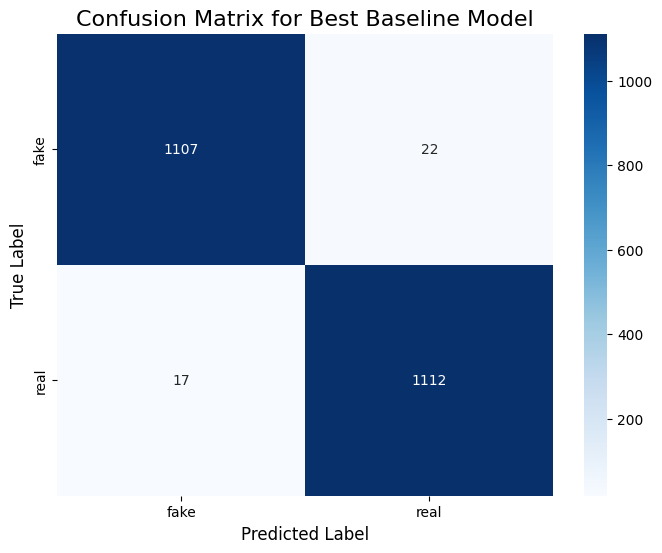

In [13]:
# Visualize the Confusion Matrix

print("Generating Confusion Matrix...\n")
cm = confusion_matrix(y_test, y_pred)
labels = ['fake', 'real']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Best Baseline Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [16]:
# ---
# **NEW CELL:** Inspect Model Coefficients (Find Leaks)
# ---
print("\n--- STEP 11.5: Inspecting Model's 'Brain' to Find Leaks ---")
print("This will show us the words the model found most important.")

try:
    # Get the best-performing pipeline
    best_pipeline = grid_search.best_estimator_

    # Get the two "tools" from the pipeline
    tfidf_vectorizer = best_pipeline.named_steps['tfidf']
    logistic_model = best_pipeline.named_steps['clf']

    # Get the list of all words (features) the TF-IDF model learned
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the "importance" (coefficient) for each word
    # The model has one set of coefficients, at index 0
    coefficients = logistic_model.coef_[0]

    # Check if the model mapped 'fake' to 0 and 'real' to 1
    # We can get this from the model's 'classes_' attribute
    if logistic_model.classes_[0] == 'fake' and logistic_model.classes_[1] == 'real':
        # 'real' is the positive class (class 1)
        # 'fake' is the negative class (class 0)

        # Zip words and their importances together
        feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: x[1])

        # Get the Top 20 "FAKE" words
        # (These will have the most negative coefficients)
        top_20_fake = feature_importance[:20]

        # Get the Top 20 "REAL" words
        # (These will have the most positive coefficients)
        top_20_real = feature_importance[-20:]

        print("\n--- TOP 20 'FAKE' NEWS INDICATORS ---")
        print("(Words with strong negative coefficients. If these are 'noise', it's a leak.)")
        for word, score in top_20_fake:
            print(f"{word}: {score:.4f}")

        print("\n--- TOP 20 'REAL' NEWS INDICATORS ---")
        print("(Words with strong positive coefficients. If these are 'noise', it's a leak.)")
        # We reverse the list to show highest-to-lowest
        for word, score in reversed(top_20_real):
            print(f"{word}: {score:.4f}")

    else:
        print("\n[ERROR] Model class mapping is not 'fake'/'real'. Cannot determine feature importance.")

except Exception as e:
    print(f"\n[ERROR] Could not inspect model coefficients: {e}")


--- STEP 11.5: Inspecting Model's 'Brain' to Find Leaks ---
This will show us the words the model found most important.

--- TOP 20 'FAKE' NEWS INDICATORS ---
(Words with strong negative coefficients. If these are 'noise', it's a leak.)
via: -129.8297
read more: -104.8374
entire story: -55.7078
president trump: -38.9035
rep: -34.2117
pic: -32.4874
sen: -30.9414
wfb: -28.7575
watch: -28.1741
gop: -26.3915
breitbart: -23.1238
didn: -20.6282
hillary: -20.5083
track: -18.8603
today: -17.3977
daily: -16.8221
this: -16.0041
daily mail: -15.1252
read: -13.4952
nyp: -13.1144

--- TOP 20 'REAL' NEWS INDICATORS ---
(Words with strong positive coefficients. If these are 'noise', it's a leak.)
on wednesday: 39.5397
on thursday: 37.9921
reuters: 36.6832
on tuesday: 35.8262
republican: 34.3703
said: 32.6351
president donald: 32.4665
on friday: 29.6332
on monday: 24.8381
bit ly: 19.8569
independent: 17.0594
president barack: 16.4856
democrat hillary: 16.1968
said on: 15.5380
the nov: 14.7265
includi

Generating ROC AUC Curve...



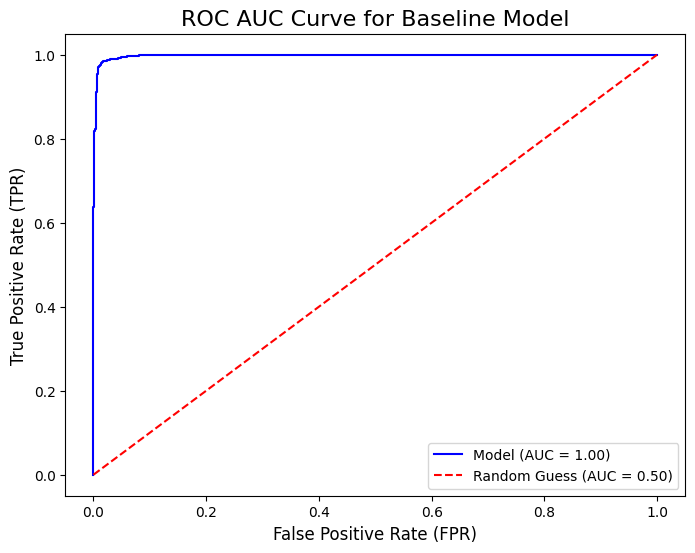

In [14]:
# Visualize the ROC AUC Curve

print("Generating ROC AUC Curve...\n")
# Calculate the points for the curve
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_probs)

plt.figure(figsize=(8, 6))
# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label=f'Model (AUC = {auc_score:.2f})')
# Plot the "random guess" line
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess (AUC = 0.50)')
plt.title('ROC AUC Curve for Baseline Model', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend()
plt.show()

In [15]:
# Save the Best Model

print("Saving the best trained model pipeline...")
# The 'grid_search.best_estimator_' is our final, trained pipeline
joblib.dump(grid_search.best_estimator_, model_save_path)
print(f"Model saved to: {model_save_path}")

print("\n--- Baseline Model Development Complete ---")

Saving the best trained model pipeline...
Model saved to: /content/drive/MyDrive/Research/models/baseline_model.pkl

--- Baseline Model Development Complete ---
